# Chat bot test with tensorflow seq2seq model 

## getting started


Code is an modification of the tensorflow seq2seq tutorial that can be found [here](https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention).

Paper on seq2seq modeling can be found (here)[https://arxiv.org/pdf/1409.3215.pdf]

Nice blogpost on [seq2seq](http://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)

To train the chatbot, dialogs are considered as follows: line 1 is a 'question', then line 2 is an 'answer', line 3 is a 'question', line 4 is an 'answer', etc....

In [1]:
import pickle
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
from sklearn.model_selection import train_test_split

import tweede_kamer_TF_chatbot as tk
from tweede_kamer_TF_chatbot import Encoder ,Decoder, BahdanauAttention, train_step, evaluate

## Preprocess function

we need lists of pairs with start end, like the exmaple below

In [2]:
pairs_ = [
    [
        'jackie exhales what the hell was that for ? ',
        'shall i call security or do you think'
    ],
    [
        'you can control yourself ? stephanie are you proud',
        'of yourself stealing from us ? <end>'
    ],
    [
        '<> jackie was something stolen ? stephanie was something',
        ' stolen ? oh don t you pretend with me.'
    ]
]
pairs = [[tk.preprocess_sentence(w) for w in pair]  for pair in pairs_]
pairs

[['<start> jackie exhales what the hell was that for ? <end>',
  '<start> shall i call security or do you think <end>'],
 ['<start> you can control yourself ? stephanie are you proud <end>',
  '<start> of yourself stealing from us ? end <end>'],
 ['<start> jackie was something stolen ? stephanie was something <end>',
  '<start> stolen ? oh don t you pretend with me . <end>']]

In [2]:
# for example the bold and the beautifull examples
pairs_ = pickle.load( open( "TheBoldPairs.pck", "rb" ) )
pairs = [[tk.preprocess_sentence(w) for w in pair]  for pair in pairs_]

## import kamer speeches

In [4]:
## put data chuncks in one zip file
#!cat data/CorpusTweedeKamer* > CorpusTweedeKamer.zip

In [2]:
%%time
tweede_kamer = pd.read_csv("CorpusTweedeKamer.zip")
tweede_kamer = (
    tweede_kamer
    .assign(datum = pd.to_datetime(tweede_kamer.date))
    .assign(speaker = tweede_kamer.speaker.str.lower())
)

CPU times: user 13 s, sys: 974 ms, total: 14 s
Wall time: 14.3 s


In [3]:
tweede_kamer.shape

(1143366, 12)

In [19]:
recente_speeches = (
    tweede_kamer
    .dropna(subset = ["text"])
    .query('terms < 600')
    .query('datum >= "2019-05-01"')
)

In [20]:
recente_speeches.shape

(13731, 12)

In [21]:
recente_speeches

,date,agenda,speechnumber,speaker,party,party.facts.id,chair,terms,text,parliament,iso3country,datum
1129244,2019-05-14,NaN,1,de voorzitter,NaN,NaN,True,44,Deze keer beginnen we met de vraag van de heer...,NL-TweedeKamer,NLD,2019-05-14
1129245,2019-05-14,NaN,2,de heer markuszower,PVV,298.0,False,374,"Dank u wel, voorzitter. Bijna alle Nederlander...",NL-TweedeKamer,NLD,2019-05-14
1129246,2019-05-14,NaN,3,de voorzitter,NaN,NaN,True,9,Dan geef ik nu het woord aan de minister.,NL-TweedeKamer,NLD,2019-05-14
1129247,2019-05-14,NaN,4,minister grapperhaus,NaN,NaN,False,466,Voorzitter. Het is goed dat deze mondelinge vr...,NL-TweedeKamer,NLD,2019-05-14
1129248,2019-05-14,NaN,5,de voorzitter,NaN,NaN,True,14,Dank u wel. Ook voor de minister geldt twee mi...,NL-TweedeKamer,NLD,2019-05-14
...,...,...,...,...,...,...,...,...,...,...,...,...
1143361,2019-07-04,NaN,965,staatssecretaris broekers-knol,NaN,NaN,False,142,Dan de motie op stuk nr. 2519 van de heer Hidd...,NL-TweedeKamer,NLD,2019-07-04
1143362,2019-07-04,NaN,966,de voorzitter,NaN,NaN,True,3,Dank u wel.,NL-TweedeKamer,NLD,2019-07-04
1143363,2019-07-04,NaN,967,de voorzitter,NaN,NaN,True,62,Over exact 60 minuten gaan wij stemmen over de...,NL-TweedeKamer,NLD,2019-07-04
1143364,2019-07-04,NaN,968,mevrouw van toorenburg,CDA,1157.0,False,21,Toch nog even — misschien is het allemaal afge...,NL-TweedeKamer,NLD,2019-07-04


In [22]:
speeches = recente_speeches.text.str.lower().values.tolist()

## Pre processing

In [3]:
input_tensor, target_tensor, inp_lang, targ_lang = tk.load_dataset(pairs)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = tk.max_length(target_tensor), tk.max_length(input_tensor)

In [4]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

922 922 231 231


In [5]:
print ("Input Language; index to word mapping")
tk.convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
tk.convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
5 ----> you
118 ----> ve
415 ----> become
9 ----> the
618 ----> queen
15 ----> of
619 ----> knock
620 ----> offs
3 ----> .
2 ----> <end>

Target Language; index to word mapping
2 ----> <start>
10 ----> a
316 ----> knock
161 ----> off
202 ----> place
1 ----> .
5 ----> you
95 ----> ve
406 ----> stolen
144 ----> everything
1 ----> .
3 ----> <end>


In [6]:
BUFFER_SIZE     = len(input_tensor_train)
BATCH_SIZE      = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim   = 256
units           = 1024
vocab_inp_size  = len(inp_lang.word_index)+1
vocab_tar_size  = len(targ_lang.word_index)+1

dataset         = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset         = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [7]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 19]), TensorShape([64, 20]))

## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

## define the encoder, attention and decoder classes

In [8]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 19, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [9]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 19, 1)


In [10]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(
    tf.random.uniform((64, 1)),
    sample_hidden, 
    sample_output
)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 1390)


## Optimizer

In [11]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True,
    reduction = 'none'
)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [12]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    optimizer = optimizer,
    encoder = encoder,
    decoder = decoder
)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [13]:
EPOCHS = 5
losses = []

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden, encoder, decoder, targ_lang, BATCH_SIZE,loss_function, optimizer)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
  
  losses.append(total_loss / steps_per_epoch)

Epoch 1 Batch 0 Loss 3.0873
Epoch 1 Loss 2.6494
Time taken for 1 epoch 70.70588302612305 sec

Epoch 2 Batch 0 Loss 2.3333
Epoch 2 Loss 2.2518
Time taken for 1 epoch 37.73046517372131 sec

Epoch 3 Batch 0 Loss 2.3042
Epoch 3 Loss 2.1611
Time taken for 1 epoch 38.69601511955261 sec

Epoch 4 Batch 0 Loss 2.0401
Epoch 4 Loss 2.1029
Time taken for 1 epoch 38.696847677230835 sec

Epoch 5 Batch 0 Loss 2.1790
Epoch 5 Loss 2.0369
Time taken for 1 epoch 43.37708401679993 sec



<Figure size 432x288 with 0 Axes>

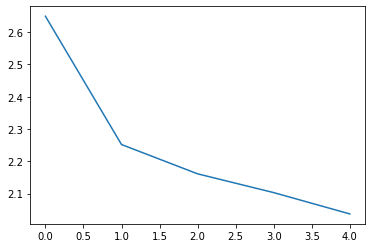

In [16]:
plt.figure()
fig, ax = plt.subplots()
plt.plot(losses)

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [15]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [20]:
def translate(sentence, max_length_targ, max_length_inp, units, encoder, decoder, inp_lang, targ_lang, plot = False):
    result, sentence, attention_plot = evaluate(sentence, max_length_targ, max_length_inp, units, encoder, decoder, inp_lang, targ_lang)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    if plot:
      plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [17]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [22]:
translate(u'are you going now', max_length_targ, max_length_inp, units, encoder, decoder, inp_lang, targ_lang)

Input: <start> are you going now <end>
Predicted translation: i . <end> 
